# **Aim**

---

The aim of developing an image caption generator is to build a model that can generate a descriptive and meaningful textual description of an image.  
This has various practical applications, including assisting visually impaired individuals to better understand visual content, aiding search engines in retrieving images based on text-based queries, etc.

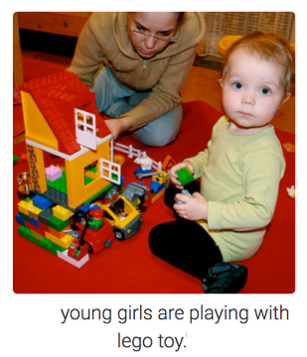

In [ ]:
import matplotlib.pyplot as plt #To plot loss, accuracy graphs 
import tensorflow as tf #To perform ML operations 
import os #to do file related operations
import keras #to perform NN related operations
import numpy as np
import pandas as pd #mainly to create dataframe objects
import cv2 #to perform image related operations
from collections import Counter #Counter is a dictionary like container that stores keys and their counts
import string # for data(Captions) preprocessing 
from copy import copy
from IPython.display import clear_output #to clear output after running cells 

In [ ]:
!pip install -U --no-cache-dir gdown --pre 
clear_output()

In [2]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip #Downloading the dataset 
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
clear_output()

In [3]:
!unzip /content/Flickr8k_Dataset.zip #unzipping the dataset 
!unzip /content/Flickr8k_text.zip
clear_output()

## **Understanding the dataset**   

---



1.) Captions (Flickr8k.token.txt)
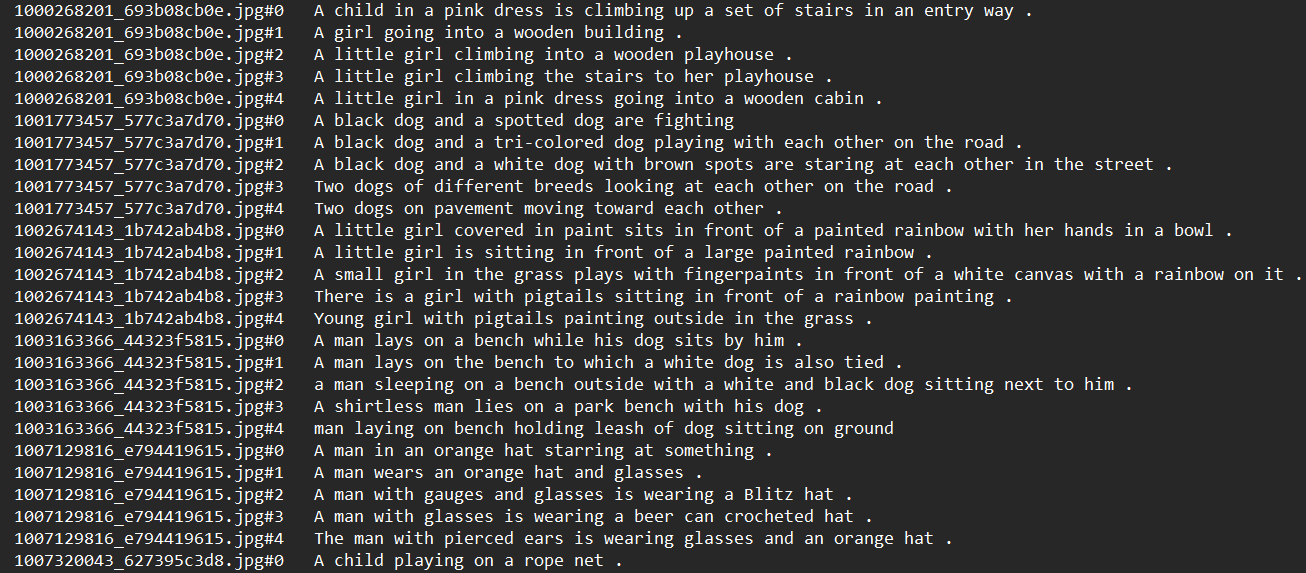

2.) Images (Flicker8k_Dataset)
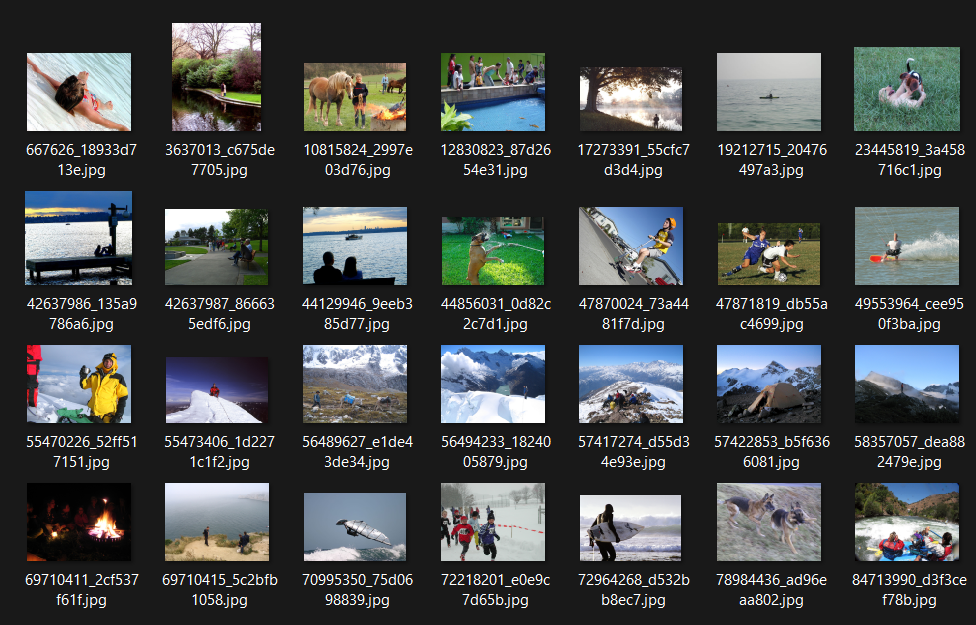





In [4]:
dir_Flickr_jpg='/content/Flicker8k_Dataset/' 
dir_Flickr_text='/content/Flickr8k.token.txt'

In [5]:
file=open(dir_Flickr_text,"r",encoding="utf8") #opening Flickr8k.token.txt in read mode to extract text from it
text=file.read()
file.close()
a=[]
for line in text.split("\n"): # split() function is used to split a string into a list of strings after breaking the given string by the specified 
                              # separator. Default separator is any whitespace.
 col=line.split("\t")
 
 if len(col)==2:
   t=col[0].split("#")
   a.append(t+[col[1].lower()])

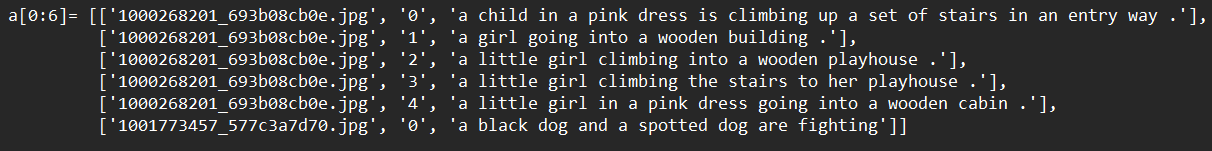

In [6]:
df_txt=pd.DataFrame(a,columns=["filename","index","caption"]) #Creating a dataframe of the values present in 'a'. 
# Pandas DataFrame is two-dimensional size-mutable heterogeneous tabular data structure.
# size-mutable here means that, records can be appended or deleted from the dataframe at any time.

In [7]:
df_txt[:10]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,a black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,2,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,3,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,4,two dogs on pavement moving toward each other .


In [7]:
unique_filenames=np.unique(df_txt.filename) # saving unique filenames in a numpy array named 'unique_filenames'

In [8]:
#In jupyter notebook, cv2.imshow() fails due to issues with the Jupyter notebook kernel. 
#Hence we will use cv2_imshow() function provided by the 'google.colab.patches' module to display images. 
from google.colab.patches import cv2_imshow

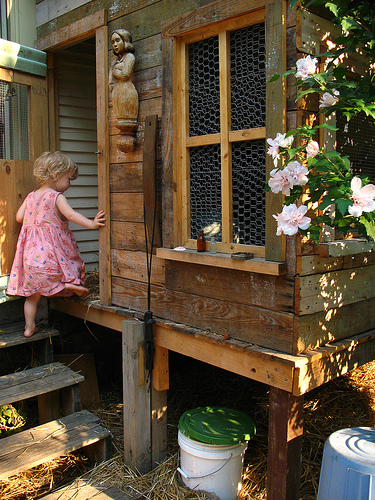

a child in a pink dress is climbing up a set of stairs in an entry way .
a girl going into a wooden building .
a little girl climbing into a wooden playhouse .
a little girl climbing the stairs to her playhouse .
a little girl in a pink dress going into a wooden cabin .


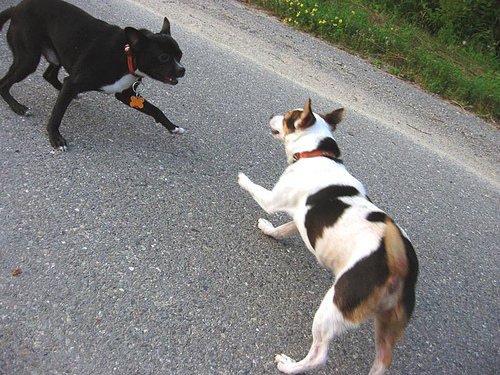

a black dog and a spotted dog are fighting
a black dog and a tri-colored dog playing with each other on the road .
a black dog and a white dog with brown spots are staring at each other in the street .
two dogs of different breeds looking at each other on the road .
two dogs on pavement moving toward each other .


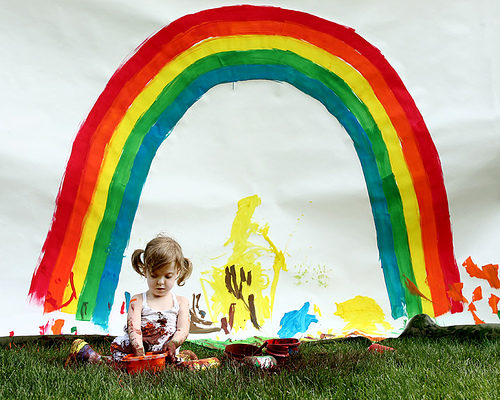

a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
a little girl is sitting in front of a large painted rainbow .
a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
there is a girl with pigtails sitting in front of a rainbow painting .
young girl with pigtails painting outside in the grass .


In [9]:
for photo_names in unique_filenames[:3]:
  full_path=dir_Flickr_jpg+photo_names
  im_g=cv2.imread(full_path)
  cv2_imshow(im_g)
  y=-1
  for names in df_txt.filename:
    y=y+1
    if names==photo_names:
      print(df_txt.caption[y])

#Preprocessing captions for training 
Captions needs to be cleaned because they can contain noise, irrelevant or redundant information that can confuse or mislead the model.

In [11]:
def remove_punctuations(str_ing):
    for i in string.punctuation: #string.punctuation returns a string that cantains all punctuation characters.
        str_ing=str_ing.replace(f"{i}","") #String replace() returns a copy of the string where occurrences of a substring (here, punctuations) are  
                                           #replaced with another substring (here, "").
    return(str_ing)

def remove_single_char(no_punctuation_str_ing):
    text_with_no_single_char=""
    for f in no_punctuation_str_ing.split():
        if len(f)!=1:
            text_with_no_single_char += " "+ f
    return(text_with_no_single_char)

def remove_numeric(text):
  text_with_no_numeric=""
  for word in text.split():     
     if word.isalpha(): #isalpha() returns True if all the characters are alphabet letters (a-z).
       text_with_no_numeric +=" "+ word
     else:
       continue
  return(text_with_no_numeric) 

def text_clean(original_text):
  text= remove_punctuations(original_text)
  text= remove_single_char(text)
  text= remove_numeric(text)
  return(text)         

In [12]:
#preprocessing captions for training 
for i , caption in enumerate(df_txt.caption):
  new_caption=text_clean(caption)
  df_txt.caption.iloc[i]=new_caption  

In [13]:
def add_start_end_seq_token(captions):
 caps=[]
 for text in captions:
   text='startseq '+text+' endseq'
   caps.append(text)
 return(caps) 
df_txt0=copy(df_txt)

df_txt0.caption=add_start_end_seq_token(df_txt.caption)
del df_txt


In [14]:
df_txt0[:5] 

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


# **Loading Pretrained VGG16**

In [14]:
model_vgg=keras.applications.vgg16.VGG16()
clear_output()

In [15]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Deleting the last layer of the model**

We need to delete the last layer of VGG-16 because we will be using it for feature extraction only.

In [16]:
model_vgg2=keras.models.Sequential()
for layer in model_vgg.layers[:-1]: #iterating till last second layer
  model_vgg2.add(layer) #adding layer into our new model
model_vgg2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [17]:
from keras.applications.vgg16 import preprocess_input #to preprocess image according to vgg16 input 
from collections import OrderedDict #dictionary subclass that preserves the order in which the keys are inserted. 
from tensorflow.keras.utils import load_img, img_to_array

In [18]:
jpgs=os.listdir(dir_Flickr_jpg)
images=OrderedDict()
# data=np.zeros((len(jpgs),224,224,3))
for i,img_name in enumerate(jpgs):
    file_path=dir_Flickr_jpg+"/"+img_name
    img=load_img(file_path,target_size=(224,224,3))
    img=img_to_array(img)
    img=preprocess_input(img)
    img=img.reshape( (1,) + img.shape) #reshaping the image because we need to add batch size (i.e 1) to the image shape in order to match the input shape of vgg 16.   
    y_pred = model_vgg2.predict(img)
    images[img_name]=y_pred.flatten()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


In [19]:
dimages,keepindex=[],[]
df_txt0=df_txt0.loc[df_txt0["index"].values=="0",:]
for i , filename in enumerate(df_txt0.filename):
  if filename in images.keys():
    dimages.append(images[filename])
    keepindex.append(i)
fnames=df_txt0["filename"].iloc[keepindex].values 
dcaptions=df_txt0["caption"].iloc[keepindex].values 
dimages=np.array(dimages)  

# **Tokenizing captions for further processing**
As the model can't take texts as an input, they need to converted into vectors.



In [20]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=6000)
tokenizer.fit_on_texts(dcaptions)
# print(tokenizer)
dtexts=tokenizer.texts_to_sequences(dcaptions)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = np.max([len(text) for text in dtexts])

# Splitting the dataset into Training and Testing data



In [22]:
prop_test, prop_val = 0.2, 0.2 
N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

In [23]:
dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

# Processing the captions and images as per the required shape by the model

In [24]:
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)

    assert(N==len(dimages)) 
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)  

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

 (49631, 30) (49631, 4096) (49631, 4476)
 (16353, 30) (16353, 4096) (16353, 4476)


In [25]:
Ximage_train.shape[1]

4096

In [26]:
Ximage_train.shape

(49631, 4096)

# Building the model

In [27]:
from keras import layers,models
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import LeakyReLU, PReLU

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)

se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)

decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_3[0][0]']                
                                                                                                  
 CaptionFeature (LSTM)          (None, 30, 256)      328704      ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 30, 256)      0           ['CaptionFeature[0][0]']         
                                                                                              

# Plotting

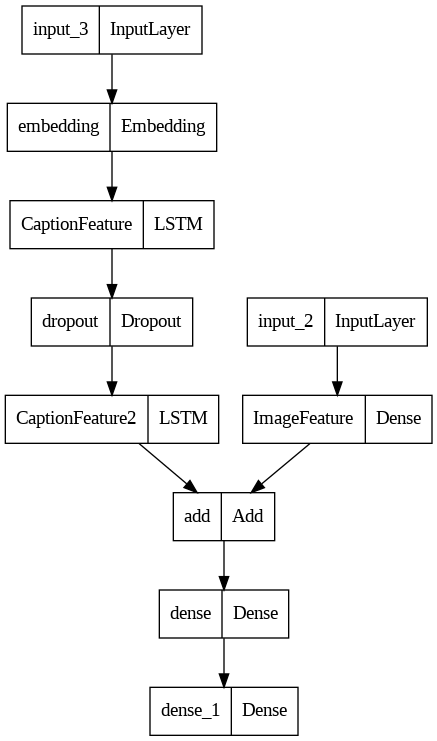

In [28]:
tf.keras.utils.plot_model(model)

# Training

In [33]:
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))

Epoch 1/5
1551/1551 - 227s - loss: 5.3578 - val_loss: 4.8511 - 227s/epoch - 146ms/step
Epoch 2/5
1551/1551 - 204s - loss: 4.4643 - val_loss: 4.5489 - 204s/epoch - 132ms/step
Epoch 3/5
1551/1551 - 201s - loss: 4.0473 - val_loss: 4.4635 - 201s/epoch - 129ms/step
Epoch 4/5
1551/1551 - 201s - loss: 3.7844 - val_loss: 4.5002 - 201s/epoch - 129ms/step
Epoch 5/5
1551/1551 - 201s - loss: 3.5777 - val_loss: 4.6134 - 201s/epoch - 130ms/step


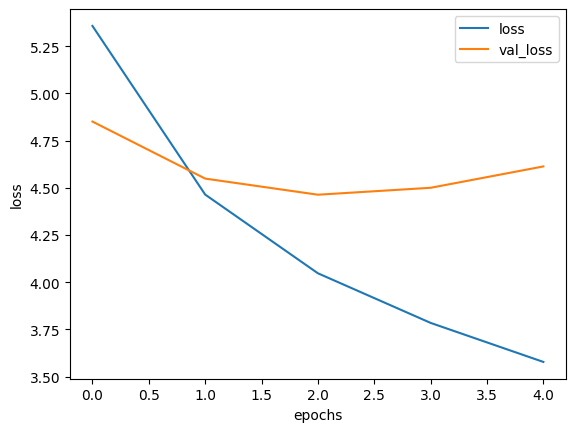

In [34]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show() 

In [35]:
model.save("/content/")

In [ ]:
model.save_weights("/content/my_weights.h5")

# Inference

In [33]:
!gdown --id 1-gUieho0x5zDUN8RQV8U01TPFF4y4xuH  #Downloading pretrained weights

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-gUieho0x5zDUN8RQV8U01TPFF4y4xuH
To: /content/Image_Caption_Generator.h5
100% 40.9M/40.9M [00:01<00:00, 36.0MB/s]


In [35]:
model.load_weights("/content/Image_Caption_Generator.h5") #Loading pretrained weights

In [36]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    in_text = 'startseq'
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " "+ newword
        if newword == "endseq":
            break
    return(in_text)

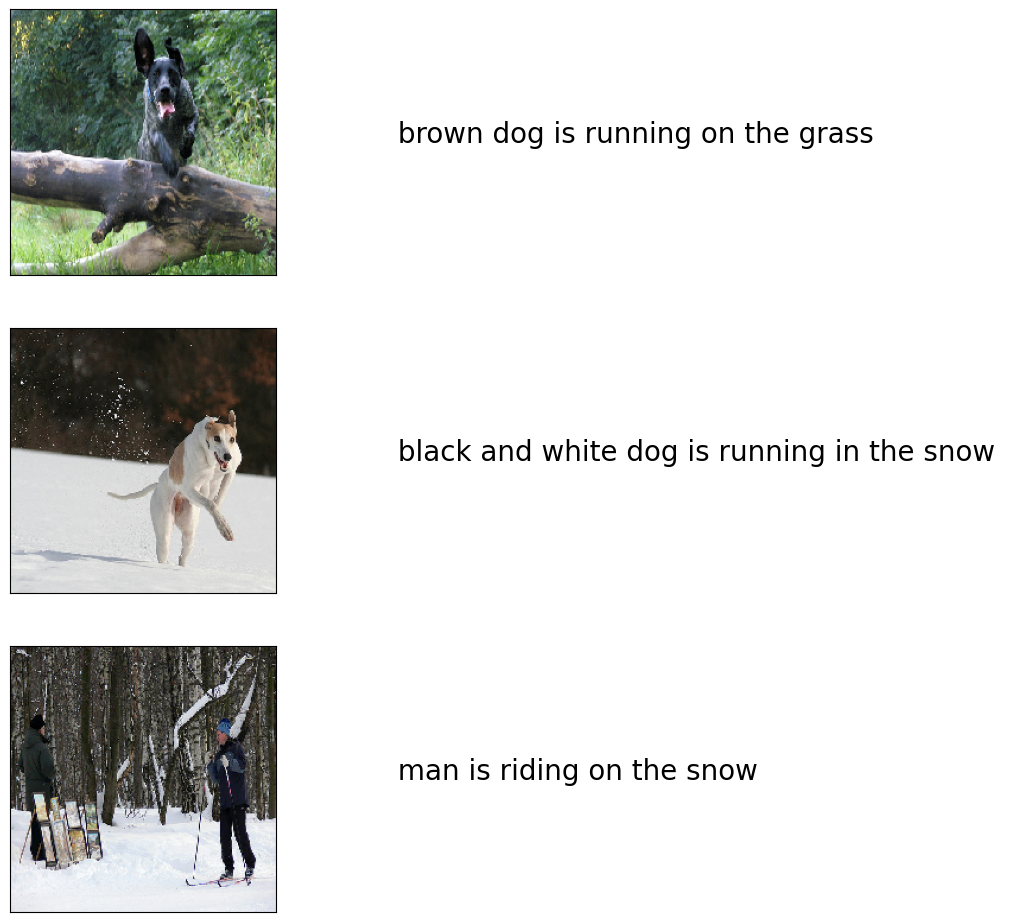

In [39]:
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[9:12],di_test[9:12]):
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=(224,224,3))
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption=caption.replace("startseq","")
    caption=caption.replace("endseq","")
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()